<a href="https://colab.research.google.com/github/WoradeeKongthong/daily_total_female_births/blob/master/daily_total_female_births_ENCODER_DECODER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENCODER-DECODER for Time Series Forecasting (Crash Course by MachineLearningMastery)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dataset

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv')

In [0]:
df

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44
...,...,...
360,1959-12-27,37
361,1959-12-28,52
362,1959-12-29,48
363,1959-12-30,55


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    365 non-null    object
 1   Births  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


Note :  
There is no missing values.

In [0]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

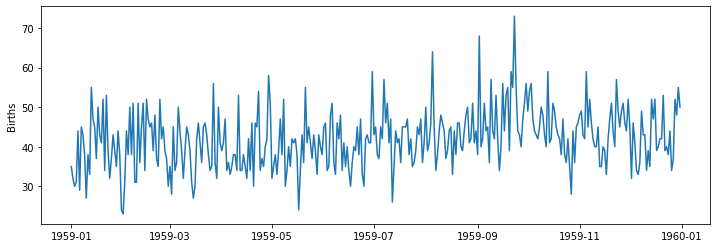

In [0]:
plt.figure(figsize=(12,4))
sns.lineplot(data=df, y=df['Births'], x=df.index.values)
plt.show()

# ENCODER-DECODER for Time Series Forecasting
ENCODER : 5 timesteps input  
DECODER : predict 2 timesteps output

In [4]:
data = df.loc[:,['Births']].values
data.shape

(365, 1)

Create dataset X and y for ENCODER-DECODER :  
X is the values of 5 days before the current day (3D array : [samples,timesteps,features]).  

In [0]:
look_back = 5
look_forward = 2
X = []
y = []
for i in range(look_back,data.shape[0]-look_forward-1):
  X.append(data[i-look_back : i])
  y.append(data[i:i+look_forward])
X = np.array(X)
y = np.array(y)

In [9]:
print('X shape : ', X.shape)
print('y shape : ', y.shape)

X shape :  (357, 5, 1)
y shape :  (357, 2, 1)


Train-test-split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Create LSTM (ENCODER + DECODER)  
Dense : learn subsequences from DECODER, then must be wrapped in TimeDistributed layer

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, RepeatVector
from keras.metrics import RootMeanSquaredError as rmse

In [0]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(RepeatVector(y.shape[1]))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse()])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 100)            80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


Fit ENC-DEC

In [0]:
history = model.fit(X_train, y_train, epochs=100, verbose=0)

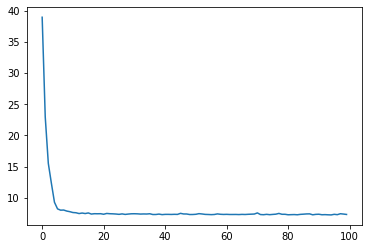

In [18]:
plt.plot(history.history['root_mean_squared_error'])
plt.show()

In [19]:
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train score (loss) : ', train_score[0])
print('Train score (rmse) : ', train_score[1])

Train score (loss) :  55.55097155654639
Train score (rmse) :  7.45325231552124


Prediction

In [0]:
y_pred = model.predict(X_test, verbose=0)

In [0]:
y_plot = y_test[:,0]

In [54]:
np.arange(1,3)

array([1, 2])

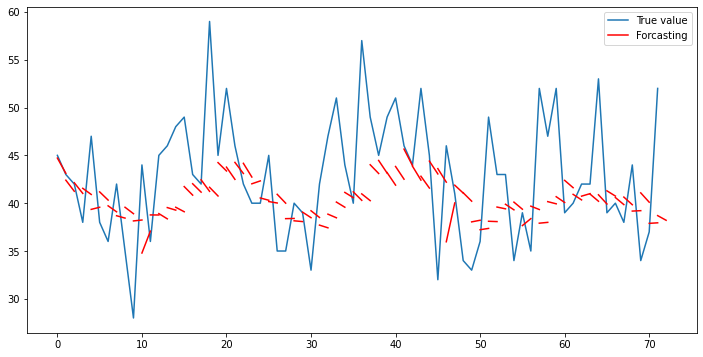

In [60]:
plt.figure(figsize=(12,6))
plt.plot(y_plot)
for i in range(len(y_pred)):
  plt.plot(np.arange(i,i+look_forward), y_pred[i], c='red')
plt.legend(['True value','Forcasting'])
plt.show()

In [52]:
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test score (loss) : ', test_score[0])
print('Test score (rmse) : ', test_score[1])

Test score (loss) :  43.714835696750214
Test score (rmse) :  6.611719608306885
